In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
rootdirectory = "/content/drive/My Drive/pytorch_udemy/05-Atrium-Segmentation/"

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
root = Path("/content/drive/My Drive/pytorch_udemy/06-Atrium-Segmentation/Task02_Heart/imagesTr/")
label = Path("/content/drive/My Drive/pytorch_udemy/06-Atrium-Segmentation/Task02_Heart/labelsTr/")

In [5]:
import os 

for filename in os.listdir(label):
  pre, ext = os.path.splitext(filename)
  os.rename(os.path.join(label, filename), os.path.join(label, pre + '.nii.gz'))


In [6]:
def change_img_to_label_path(path):
  parts = list(path.parts)
  parts[parts.index("imagesTr")] = "labelsTr"
  return Path(*parts)

In [7]:
sample_path = list(root.glob("la*"))[0]
sample_path_label = change_img_to_label_path(sample_path)

In [8]:
sample_path, sample_path_label

(PosixPath('/content/drive/My Drive/pytorch_udemy/06-Atrium-Segmentation/Task02_Heart/imagesTr/la_005.nii.gz'),
 PosixPath('/content/drive/My Drive/pytorch_udemy/06-Atrium-Segmentation/Task02_Heart/labelsTr/la_005.nii.gz'))

In [9]:
data = nib.load(sample_path)
label = nib.load(sample_path)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [10]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [27]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from celluloid import Camera
from IPython.display import HTML

In [29]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
  plt.imshow(mri[:,:,i], cmap='bone')
  mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
  camera.snap()
animation=camera.animate()

<IPython.core.display.Javascript object>

In [30]:
HTML(animation.to_html5_video())

In [12]:
def normalize(full_volume): #perform z-normalization
  mu = full_volume.mean()
  std = np.std(full_volume)
  normalized = (full_volume - mu) / std
  return normalized

def standardize(normalized):
  standardized = (normalized - normalized.min() / normalized.max() - normalized.min())
  return standardized

In [13]:
all_files = list(root.glob("la*"))
len(all_files)

20

In [14]:
for counter, path_to_mri_data in enumerate(tqdm(all_files)):

  path_to_label = change_img_to_label_path(path_to_mri_data)
  label_data = nib.load(path_to_label)
  print(label_data)

  0%|          | 0/20 [00:00<?, ?it/s]

<class 'nibabel.nifti1.Nifti1Image'>
data shape (320, 320, 120)
affine: 
[[1.25 0.   0.   0.  ]
 [0.   1.25 0.   0.  ]
 [0.   0.   1.37 0.  ]
 [0.   0.   0.   1.  ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 320 320 120   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.   1.25 1.25 1.37 0.   0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b''
qform_code      : scanner
sform_code      

In [18]:
save_root = Path("/content/drive/My Drive/pytorch_udemy/06-Atrium-Segmentation/Preprocessed/")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):

  path_to_label = change_img_to_label_path(path_to_mri_data)
  mri = nib.load(path_to_mri_data)
  assert nib.aff2axcodes(mri.affine) == ("R","A", "S")
  mri_data = mri.get_fdata()
  label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)
  # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
  # Addtionally crop front and back with same size. Dont crop viewing axis
  mri_data = mri_data[32:-32, 32:-32]
  label_data = label_data[32:-32, 32:-32]
  #Normalize and standardize the images
  normalized_mri_data = normalize(mri_data)
  standardized_mri_data = standardize(normalized_mri_data)
# Check if train or val data and create corresponding path
  if counter < 17:
    current_path = save_root/"train"/str(counter)
  else:
    current_path = save_root/"val"/str(counter)
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
  for i in range(standardized_mri_data.shape[-1]):
      slice = standardized_mri_data[:,:,i]
      mask = label_data[:,:,i]
      slice_path = current_path/"data"
      mask_path = current_path/"masks"
      slice_path.mkdir(parents=True, exist_ok=True)
      mask_path.mkdir(parents=True, exist_ok=True)
      np.save(slice_path/str(i), slice)
      np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

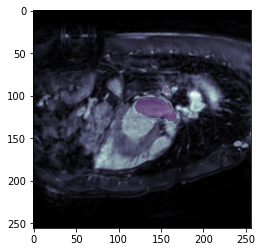

In [25]:
path = Path("/content/drive/My Drive/pytorch_udemy/06-Atrium-Segmentation/Preprocessed/train/0")
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)
plt.figure()
plt.imshow(slice, cmap="bone")

mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_,alpha=0.5)